# Lab05: Drink Driving - Alcohol Dataset

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing._encoders import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE

from seaborn import heatmap

In [98]:
df = pd.read_csv("../datasets/dataset_alcohol.csv")

In [99]:
df = df.sample(frac=1, random_state=2)
df.reset_index(drop=True, inplace=True)

In [100]:
df.shape

(76, 9)

We will likely use k-fold cross validation due to the smaller size of the dataset.

In [101]:
df.head(3)

,age_yrs,height_cm,weight_kg,duration_mins,elapsed_mins,sex,last_meal,units,over_limit
0,21,185,85,315,10,Male,Snack,19.7,Yes
1,34,187,95,240,5,Male,Lunch,10.2,No
2,23,200,101,60,10,Male,Snack,4.8,No


In [102]:
df.describe()

,age_yrs,height_cm,weight_kg,units
count,76.000000,76.000000,76.000000,76.000000
mean,22.657895,176.644737,71.486842,8.632895
std,5.627439,8.453329,11.474602,5.775567
min,18.000000,157.000000,47.000000,0.000000
25%,19.000000,172.000000,63.000000,4.275000
50%,21.000000,177.000000,72.000000,8.400000
75%,23.000000,182.000000,79.000000,12.100000
max,45.000000,200.000000,101.000000,31.200000


In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76 entries, 0 to 75
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   age_yrs        76 non-null     int64  
 1   height_cm      76 non-null     int64  
 2   weight_kg      76 non-null     int64  
 3   duration_mins  76 non-null     object 
 4   elapsed_mins   76 non-null     object 
 5   sex            76 non-null     object 
 6   last_meal      65 non-null     object 
 7   units          76 non-null     float64
 8   over_limit     76 non-null     object 
dtypes: float64(1), int64(3), object(5)
memory usage: 5.5+ KB


_last\_meal_ has null values, these will be imputed because dropping these rows reduces the size of an already small dataset.

In [104]:
df.columns

Index(['age_yrs', 'height_cm', 'weight_kg', 'duration_mins', 'elapsed_mins',
       'sex', 'last_meal', 'units', 'over_limit'],
      dtype='object')

Duration - total time drinking
Elapsed - time since last drink

In [105]:
df["sex"].unique()

array(['Male', 'Female'], dtype=object)

In [106]:
df["over_limit"].unique()

array(['Yes', 'No'], dtype=object)

In [107]:
features = [
    "age_yrs",
    "height_cm",
    "weight_kg",
    "duration_mins",
    "elapsed_mins",
    "sex",
    "last_meal",
    "units",
]

In [108]:
num_features = [
    "age_yrs",
    "height_cm",
    "weight_kg",
    "duration_mins",
    "elapsed_mins",
    "units",
]

In [109]:
nom_features = ["sex", "last_meal", "units"]  # over_limit is what is being predicted

In [110]:
for num_feat in num_features:
    print(f"{num_feat} has the following unique values:\n{df[num_feat].unique()}\n\n")

age_yrs has the following unique values:
[21 34 23 26 19 24 18 20 36 22 25 40 38 39 29 45 28]


height_cm has the following unique values:
[185 187 200 177 175 162 182 180 170 172 165 157 160 167]


weight_kg has the following unique values:
[ 85  95 101  76  69  57  82  63  79  66  73  88  84  71  75  72  47  60
  55  51  48  52  53  64  80]


duration_mins has the following unique values:
['315' '240' '60' '30' '180' '90' '120' '325' '330' '?' '270' '150' '360'
 '300' '5' '435']


elapsed_mins has the following unique values:
['10' '5' '15' '180' '120' '40' '?' '30' '60']


units has the following unique values:
[19.7 10.2  4.8  2.9  2.6 15.6  3.   5.  13.6 20.8 10.4  2.4  5.2 16.8
 16.1  7.2 10.   0.  12.6 13.2  9.   5.1  7.8  1.3 16.9  4.5  3.6 11.4
 12.   9.6  9.1 10.1 14.4  9.8  9.5  4.6 13.  16.6  1.2 15.8 12.4 31.2
 11.  15.   5.9]




_elapsed\_mins_ and _duration\_mins both have invalid values, that aren't null ("?"). These will also be imputed, taking the mean time across the dev_df.

In [111]:
df[df["elapsed_mins"] == "?"]

,age_yrs,height_cm,weight_kg,duration_mins,elapsed_mins,sex,last_meal,units,over_limit
22,40,170,75,?,?,Male,Lunch,0.0,No
65,18,177,57,?,?,Female,Full,0.0,No


# Explore dev_df

In [112]:
dev_df, test_df = train_test_split(df, train_size=0.8, random_state=2)

In [113]:
copy_df = dev_df.copy()

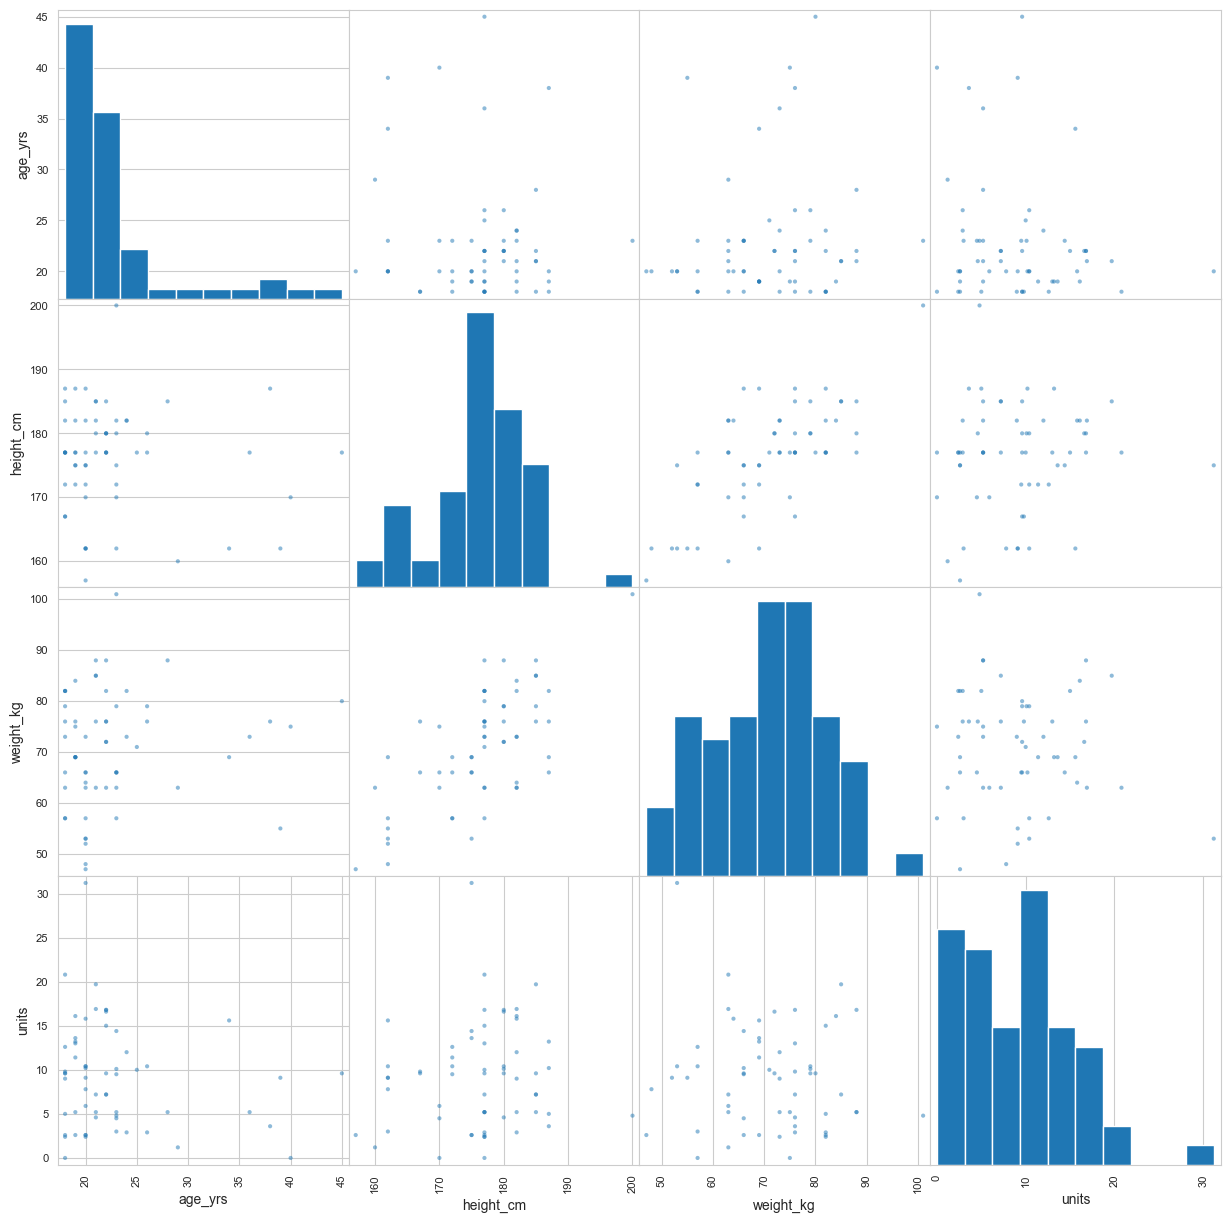

In [114]:
m = pd.plotting.scatter_matrix(copy_df, figsize=(15, 15))

<Axes: >

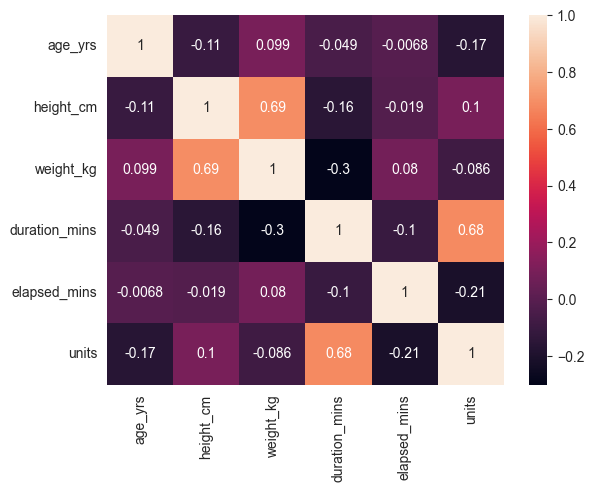

In [115]:
heatmap(copy_df[copy_df[num_features] != "?"][num_features].corr(), annot=True)

Height and weight are strongly correlated, potentially pointing to BMI being a useful feature to reduce dimensionality.

In [116]:
class InsertBMI(BaseEstimator, TransformerMixin):
    def __init__(self, insert=True):
        self.insert = insert

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        if self.insert:
            X["bmi"] = X["weight_kg"] / (X["height_cm"] / 100) ** 2
            X = X.replace([np.inf, -np.inf], np.nan)
        return X

In [117]:
class ReplaceQuestionMarks(BaseEstimator, TransformerMixin):
    def __init__(self, insert=True):
        self.insert = insert

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        if self.insert:
            X = X.replace([np.inf, -np.inf, "?"], np.nan)
        return X

In [126]:
preprocessor = ColumnTransformer(
    [
        (
            "num",
            Pipeline(
                [
                    ("replace_question", ReplaceQuestionMarks()),
                    ("bmi", InsertBMI()),
                    (
                        "mins_imputer",
                        SimpleImputer(missing_values=np.nan),
                    ),
                    ("scaler", StandardScaler()),
                ],
            ),
            num_features,
        ),
        (
            "nom",
            Pipeline(
                [
                    ("replace_question", ReplaceQuestionMarks()),
                    (
                        "imputer",
                        SimpleImputer(missing_values=np.nan, strategy="most_frequent"),
                    ),
                    ("onehotencoder", OneHotEncoder(handle_unknown="ignore")),
                ]
            ),
            nom_features,
        ),
    ],
    remainder="drop",
)

In [127]:
dev_X = dev_df[features]
test_X = test_df[features]

dev_y = dev_df["over_limit"].values
test_y = test_df["over_limit"].values

In [133]:
elim_features = (
    Pipeline(
        [
            ("preprocessor", preprocessor),
            (
                "feature_selection",
                Pipeline(
                    [
                        ("replace_question", ReplaceQuestionMarks()),
                        ("rfe", RFE(estimator=DecisionTreeClassifier())),
                    ]
                ),
                features,
            ),
        ]
    ),
)

In [134]:
logistic = Pipeline(
    [("elim_features", elim_features), ("predictor", LogisticRegression())]
)

In [135]:
logistic_param_grid = {
    "elim_features__preprocessor__num__mins_imputer__strategy": [
        "most_frequent",
        "mean",
    ],
    "elim_features__feature_selection__rfe__n_features_to_select": [
        2,
        3,
        4,
        5,
        6,
        7,
        8,
        9,
        10,
    ],
}

In [136]:
logistic_gs = GridSearchCV(
    logistic, logistic_param_grid, scoring="accuracy", cv=10, refit=True
)

logistic_gs.fit(dev_X, dev_y)
logistic_gs.best_params_, logistic_gs.best_score_

AttributeError: 'tuple' object has no attribute 'set_params'